In [1]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import numpy as np
import mlrose_hiive as mlrose
import matplotlib.pyplot as plt
import math

In [2]:
import math

def calculate_total_distance(coord_list, state):
    coords = [coord_list[i] for i in state]
    total_distance = 0.0

    # Iterate through the list of coordinates
    for i in range(len(coords) - 1):
        # Calculate the Euclidean distance between consecutive cities
        total_distance += math.sqrt((coords[i+1][0] - coords[i][0])**2 + (coords[i+1][1] - coords[i][1])**2)

    # Add the distance from the last city back to the first city (to complete the loop)
    distance_to_first = math.sqrt((coords[0][0] - coords[i][0])**2 + (coords[0][1] - coords[i][1])**2)
    total_distance += distance_to_first
    return total_distance

In [3]:
import random

# Number of points
num_points = 50

# Define range for random coordinates (adjust as needed)
x_min, x_max = 0, 100
y_min, y_max = 0, 100
i_min, i_max = 0, 100

# Generate random coordinates
points = [(random.uniform(x_min, x_max), random.uniform(y_min, y_max), int(random.uniform(i_min, i_max))) for _ in range(num_points)]

# Print the generated points
for i, point in enumerate(points[0:3]):
    print(f"Point {i+1}: {point}")

Point 1: (22.96142350895446, 78.15907638649612, 18)
Point 2: (35.10569464945136, 61.421512809329215, 44)
Point 3: (38.848085070336126, 7.470256615050996, 75)


In [4]:
""" Classes for defining fitness functions."""

# Author: Genevieve Hayes (Modified by Andrew Rollings) (Modified by Apratim Bajpai)
# License: BSD 3 clause

import numpy as np
import pandas as pd
import math

class CustomTSP:
    """Fitness function for Travelling Salesman optimization problem.
    Evaluates the fitness of a tour of n nodes, represented by state vector
    :math:`x`, giving the order in which the nodes are visited, as the total
    distance travelled on the tour (including the distance travelled between
    the final node in the state vector and the first node in the state vector
    during the return leg of the tour). Each node must be visited exactly
    once for a tour to be considered valid.

    Parameters
    ----------
    coords: list of pairs, default: None
        Ordered list of the (x, y) coordinates of all nodes (where element i
        gives the coordinates of node i). This assumes that travel between
        all pairs of nodes is possible. If this is not the case, then use
        :code:`distances` instead.

    distances: list of triples, default: None
        List giving the distances, d, between all pairs of nodes, u and v, for
        which travel is possible, with each list item in the form (u, v, d).
        Order of the nodes does not matter, so (u, v, d) and (v, u, d) are
        considered to be the same. If a pair is missing from the list, it is
        assumed that travel between the two nodes is not possible. This
        argument is ignored if coords is not :code:`None`.

    Examples
    --------
    .. highlight:: python
    .. code-block:: python

        >>> import mlrose_hiive
        >>> import numpy as np
        >>> coords = [(0, 0), (3, 0), (3, 2), (2, 4), (1, 3)]
        >>> dists = [(0, 1, 3), (0, 2, 5), (0, 3, 1), (0, 4, 7), (1, 3, 6),
                     (4, 1, 9), (2, 3, 8), (2, 4, 2), (3, 2, 8), (3, 4, 4)]
        >>> fitness_coords = mlrose_hiive.TravellingSales(coords=coords)
        >>> state = np.array([0, 1, 4, 3, 2])
        >>> fitness_coords.evaluate(state)
        13.86138...
        >>> fitness_dists = mlrose_hiive.TravellingSales(distances=dists)
        >>> fitness_dists.evaluate(state)
        29

    Note
    ----
    1. The TravellingSales fitness function is suitable for use in travelling
       salesperson (tsp) optimization problems *only*.
    2. It is necessary to specify at least one of :code:`coords` and
       :code:`distances` in initializing a TravellingSales fitness function
       object.
    """

    def __init__(self, coords=None, distances=None,
                 max_distance_travelled = 300,
                 item_price = 10, fuel_price = 0.5):

        if coords is None and distances is None:
            raise Exception("""At least one of coords and distances must be"""
                            + """ specified.""")

        elif coords is not None:
            self.is_coords = True
            path_list = []
            dist_list = []

        else:
            self.is_coords = False

            # Remove any duplicates from list
            distances = list({tuple(sorted(dist[0:2]) + [dist[2]])
                              for dist in distances})

            # Split into separate lists
            node1_list, node2_list, dist_list = zip(*distances)

            if min(dist_list) <= 0:
                raise Exception("""The distance between each pair of nodes"""
                                + """ must be greater than 0.""")
            if min(node1_list + node2_list) < 0:
                raise Exception("""The minimum node value must be 0.""")

            if not max(node1_list + node2_list) == \
                    (len(set(node1_list + node2_list)) - 1):
                raise Exception("""All nodes must appear at least once in"""
                                + """ distances.""")

            path_list = list(zip(node1_list, node2_list))

        self.coords = coords
        self.distances = distances
        self.path_list = path_list
        self.dist_list = dist_list
        self.prob_type = 'tsp'
        self.max_distance_travelled = max_distance_travelled
        self.item_price = item_price
        self.fuel_price = fuel_price


        if self.coords:
            self.calculate_fitness = self.__calculate_fitness_by_coords
        else:
            self.df_path_list = pd.DataFrame([[self.path_list[i][0], self.path_list[i][1], self.dist_list[i]] for i in range(len(self.path_list))])
            self.calculate_fitness = self.__calculate_fitness_by_distance

    def evaluate(self, state):
        """Evaluate the fitness of a state vector.

        Parameters
        ----------
        state: array
            State array for evaluation. Each integer between 0 and
            (len(state) - 1), inclusive must appear exactly once in the array.

        Returns
        -------
        fitness: float
            Value of fitness function. Returns :code:`np.inf` if travel between
            two consecutive nodes on the tour is not possible.
        """

        if self.is_coords and len(state) != len(self.coords):
            raise Exception("""state must have the same length as coords.""")

        if not len(state) == len(set(state)):
            raise Exception("""Each node must appear exactly once in state.""")

        if min(state) < 0:
            raise Exception("""All elements of state must be non-negative"""
                            + """ integers.""")

        if max(state) >= len(state):
            raise Exception("""All elements of state must be less than"""
                            + """ len(state).""")

        return self.calculate_fitness(state)

    def __calculate_fitness_by_coords(self, state):
        # Calculate length of journey

        coords = [self.coords[i] for i in state]
        total_distance = 0.0
        items = 0

        # Iterate through the list of coordinates
        for i in range(len(coords) - 1):
            # Calculate the Euclidean distance between consecutive cities
            total_distance += math.sqrt((coords[i+1][0] - coords[i][0])**2 + (coords[i+1][1] - coords[i][1])**2)
            if total_distance < self.max_distance_travelled:
                # Calculate the number of items sold
                items = items + coords[i][2]
            else:
                total_distance -= math.sqrt((coords[i+1][0] - coords[i][0])**2 + (coords[i+1][1] - coords[i][1])**2)
                break
            items = items + coords[i][2]


        # Total money
        fitness = items * self.item_price - total_distance * self.fuel_price
        # ls = len(state)
        # nodes = np.array([self.coords[state[i]] for i in range(ls)] + [self.coords[state[0]]])
        # nodes.reshape((2, nodes.size // 2))
        # fitness = np.linalg.norm(nodes[1:] - nodes[:-1], axis=1).sum()

        return fitness

    def __calculate_fitness_by_distance(self, state):

        ls = len(state)

        nodes = np.array([[state[i-1], state[i]] for i in range(1, ls)] + [[state[ls-1]] + [state[0]]])
        nodes.sort(axis=1)
        df_nodes = pd.merge(self.df_path_list, pd.DataFrame(nodes), how='inner')
        if df_nodes.shape[0] != nodes.shape[0]:
            return np.inf
        fitness = df_nodes.iloc[:, 2].sum()
        return fitness

    def get_prob_type(self):
        """ Return the problem type.

        Returns
        -------
        self.prob_type: string
            Specifies problem type as 'discrete', 'continuous', 'tsp'
            or 'either'.
        """
        return self.prob_type

In [9]:
import random

# Number of points
num_points = 50

# Define range for random coordinates (adjust as needed)
x_min, x_max = 0, 100
y_min, y_max = 0, 100
i_min, i_max = 0, 100

# Generate random coordinates
points = [(random.uniform(x_min, x_max), random.uniform(y_min, y_max), int(random.uniform(i_min, i_max))) for _ in range(num_points)]

# Print the generated points
for i, point in enumerate(points[0:3]):
    print(f"Point {i+1}: {point}")

coords_list = points

# Initialize fitness function object using coords_list
fitness_coords = CustomTSP(coords = coords_list,
                                  max_distance_travelled = 300,
                                  item_price = 10, fuel_price = 0.5)

# Define the problem object
problem = mlrose.TSPOpt(length=len(coords_list), fitness_fn = fitness_coords, maximize=True)

Point 1: (40.216923078325664, 20.301620797246056, 12)
Point 2: (44.83413480469235, 86.12084864169691, 23)
Point 3: (42.21318669175136, 10.573396895698384, 69)


In [5]:
def get_props(runner):
  times = []
  fevals = []
  fitness = []
  for i in range(42, 343, 100):
    print(i)
    runner.seed = i
    stats, curves = runner.run()
    times.append(curves.Time.values)
    fevals.append(curves.FEvals.values)
    fitness.append(curves.Fitness.values)
  return times, fevals, fitness

In [20]:
def parameter_selection_plots(means, stds, names, parameters, cs, title):
  fig, ax = plt.subplots(1, len(means), figsize =(len(means) * 5, 5))
  i = 0
  for ms,ss,n in zip(means, stds, names):
    # Plotting
    for m, s, p, c in zip(ms, ss, parameters, cs):
      ax[i].fill_between(range(1, len(m) + 1), m - s, m + s, color=c, alpha=0.3)
      ax[i].plot(range(1, len(m) + 1), m, color=c, label = str(p))
      ax[i].set_xlabel('Iteration')
      ax[i].set_ylabel(n)
      if i == 2:
        ax[i].set_ylim([2000, 30000])
      ax[i].legend()

    i += 1
  fig.suptitle(title)
  fig.tight_layout()

## RHC

In [10]:
mt = []
st = []

mfe = []
sfe = []

mf = []
sf = []
for r in [0.1, 0.25, 0.5, 0.75, 1]:
  rhc = mlrose.RHCRunner(problem=problem,
                        experiment_name='countones_ra',
                        output_directory="results/countones_ga",
                        seed=None,
                        iteration_list=2 ** np.arange(14),
                        max_attempts=2000,
                        max_iters = 2000,
                        restart_list=[0], learning_rate = r)
  times, fevals, fitness = get_props(rhc)
  mt.append(np.mean(times, axis = 0))
  st.append(np.std(times, axis = 0))

  mfe.append(np.mean(fevals, axis = 0))
  sfe.append(np.std(fevals, axis = 0))

  mf.append(np.mean(fitness, axis = 0))
  sf.append(np.std(fitness, axis = 0))

rmt, rst, rmfe, rsfe, rmf, rsf = mt, st, mfe, sfe, mf, sf

42
142
242
342
42
142
242
342
42
142
242
342
42
142
242
342
42
142
242
342


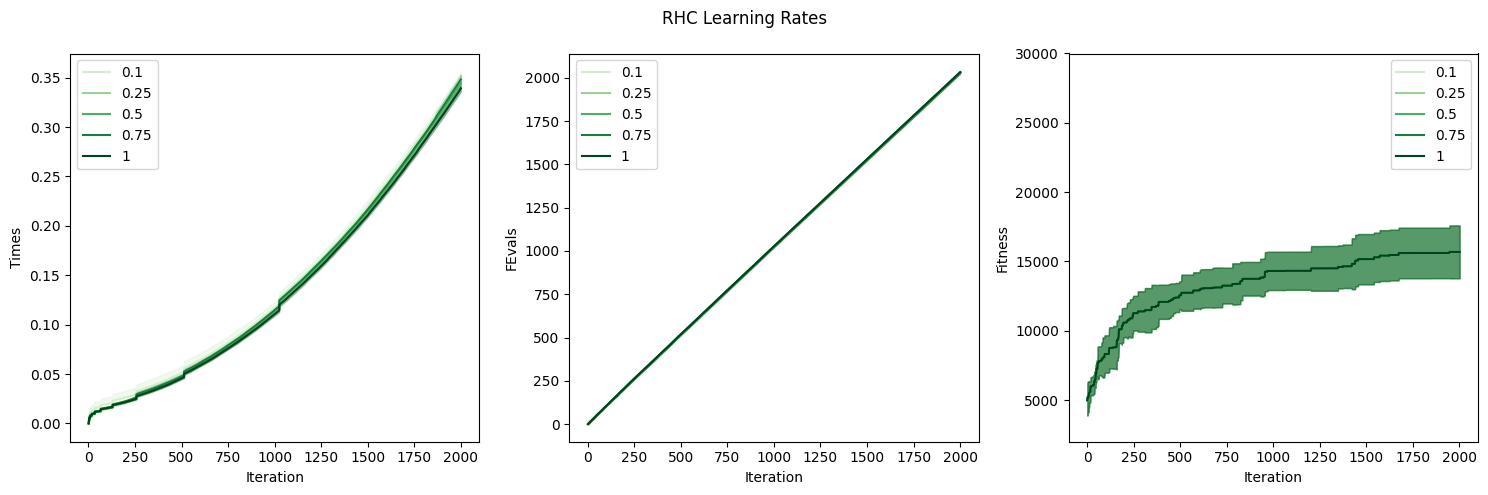

In [21]:
parameter_selection_plots([rmt, rmfe, rmf], [rst, rsfe, rsf], ["Times", "FEvals", "Fitness"], [0.1, 0.25, 0.5, 0.75, 1], plt.cm.Greens(np.linspace(0.2, 1, 5)), 'RHC Learning Rates')

## SA

In [14]:
mt = []
st = []

mfe = []
sfe = []

mf = []
sf = []
for r in [0.1, 0.25, 0.5, 0.75, 1]:
  sa = mlrose.SARunner(problem=problem,
                        experiment_name='countones_sa',
                        output_directory=None,
                        seed=None,
                        iteration_list=2 ** np.arange(14),
                        max_iters=2000,
                       max_attempts=2000,
                        temperature_list=[250],
                        decay_list=[mlrose.GeomDecay],
                        learning_rates = [r])
  times, fevals, fitness = get_props(sa)
  mt.append(np.mean(times, axis = 0))
  st.append(np.std(times, axis = 0))

  mfe.append(np.mean(fevals, axis = 0))
  sfe.append(np.std(fevals, axis = 0))

  mf.append(np.mean(fitness, axis = 0))
  sf.append(np.std(fitness, axis = 0))

smt, sst, smfe, ssfe, smf, ssf = mt, st, mfe, sfe, mf, sf

42
142
242
342
42
142
242
342
42
142
242
342
42
142
242
342
42
142
242
342


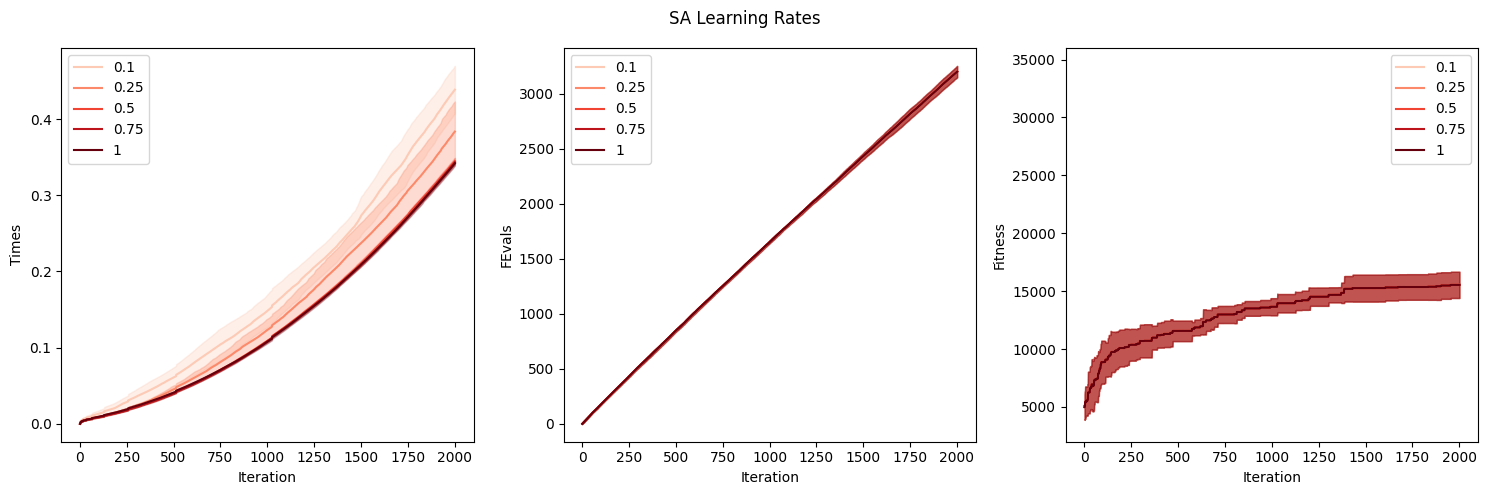

In [15]:
parameter_selection_plots([smt, smfe, smf], [sst, ssfe, ssf], ["Times", "FEvals", "Fitness"], [0.1, 0.25, 0.5, 0.75, 1], plt.cm.Reds(np.linspace(0.2, 1, 5)),'SA Learning Rates')

In [16]:
mt = []
st = []

mfe = []
sfe = []

mf = []
sf = []
for r in [1, 5, 10, 50, 100, 250]:
  sa = mlrose.SARunner(problem=problem,
                        experiment_name='countones_sa',
                        output_directory=None,
                        seed=None,
                        iteration_list=2 ** np.arange(14),
                        max_iters=2000,
                       max_attempts=2000,
                        temperature_list=[r],
                        decay_list=[mlrose.GeomDecay],
                        learning_rate = 0.5)
  times, fevals, fitness = get_props(sa)
  mt.append(np.mean(times, axis = 0))
  st.append(np.std(times, axis = 0))

  mfe.append(np.mean(fevals, axis = 0))
  sfe.append(np.std(fevals, axis = 0))

  mf.append(np.mean(fitness, axis = 0))
  sf.append(np.std(fitness, axis = 0))

smt, sst, smfe, ssfe, smf, ssf = mt, st, mfe, sfe, mf, sf

42
142
242
342
42
142
242
342
42
142
242
342
42
142
242
342
42
142
242
342
42
142
242
342


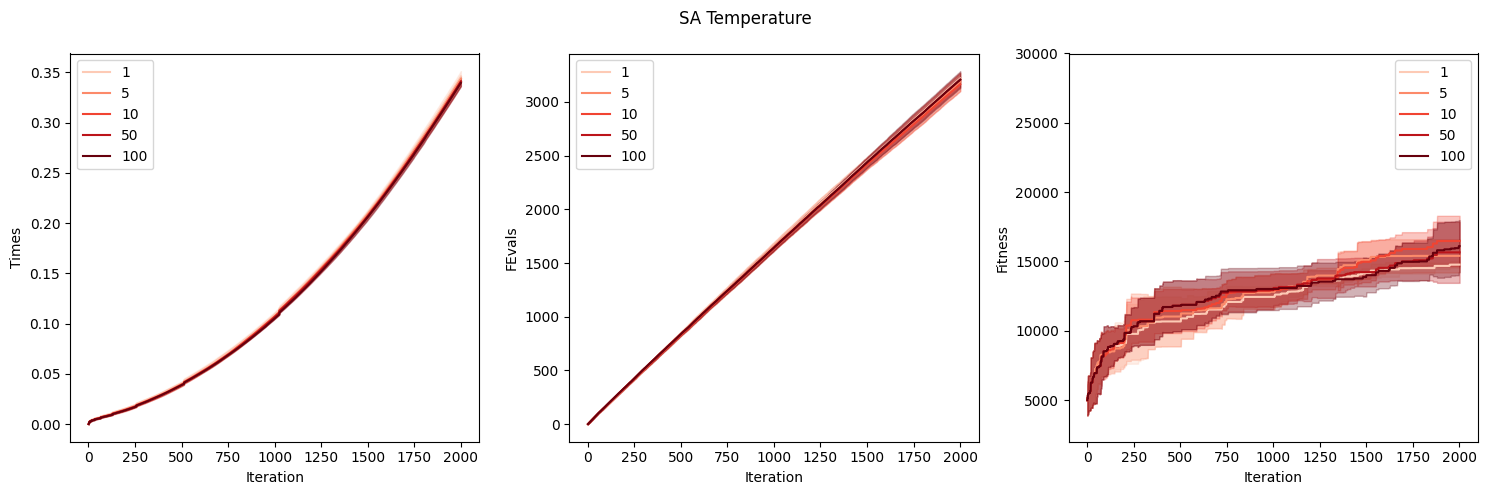

In [22]:
parameter_selection_plots([smt, smfe, smf], [sst, ssfe, ssf], ["Times", "FEvals", "Fitness"], [1, 5, 10, 50, 100, 250], plt.cm.Reds(np.linspace(0.2, 1, 5)),'SA Temperature')

## GA

In [18]:
mt = []
st = []

mfe = []
sfe = []

mf = []
sf = []
for r in [0.1, 0.25, 0.5, 0.75, 1]:
  sa = mlrose.GARunner(problem=problem,
                        experiment_name='countones_ga',
                        output_directory=None,
                        seed=None,
                        iteration_list=2 ** np.arange(14),
                        max_iters=1000,
                        max_attempts=1000,
                        population_sizes =[100],
                        mutation_rates = [r])
  times, fevals, fitness = get_props(sa)
  mt.append(np.mean(times, axis = 0))
  st.append(np.std(times, axis = 0))

  mfe.append(np.mean(fevals, axis = 0))
  sfe.append(np.std(fevals, axis = 0))

  mf.append(np.mean(fitness, axis = 0))
  sf.append(np.std(fitness, axis = 0))

gmt, gst, gmfe, gsfe, gmf, gsf = mt, st, mfe, sfe, mf, sf

42
142
242
342
42
142
242
342
42
142
242
342
42
142
242
342
42
142
242
342


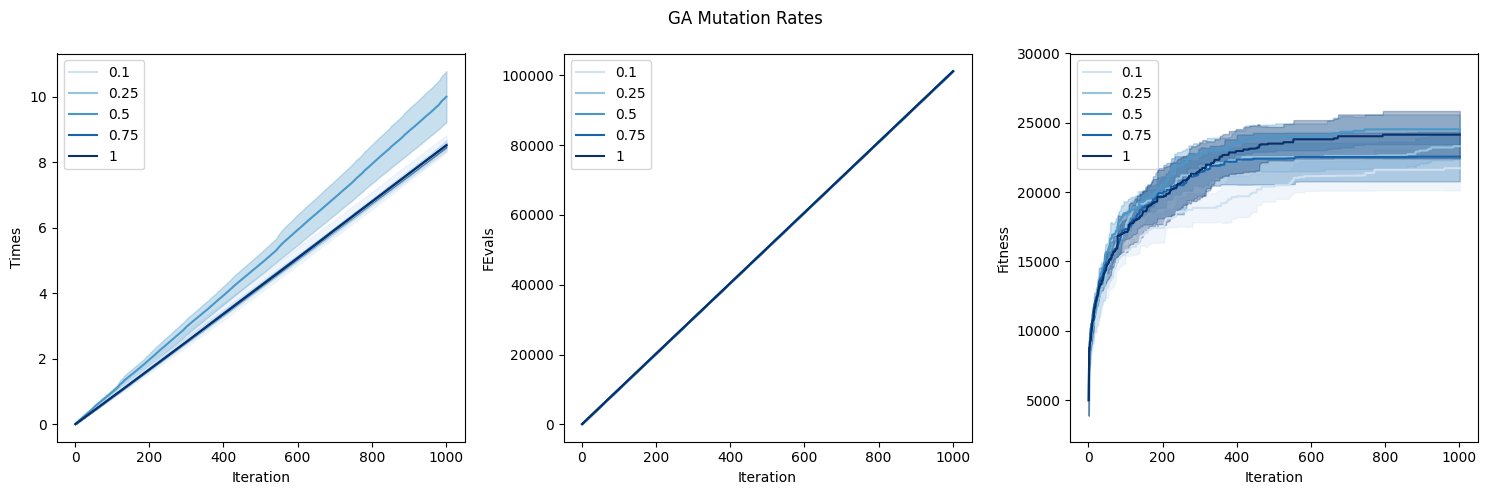

In [23]:
parameter_selection_plots([gmt, gmfe, gmf], [gst, gsfe, gsf], ["Times", "FEvals", "Fitness"], [0.1, 0.25, 0.5, 0.75, 1], plt.cm.Blues(np.linspace(0.2, 1, 5)), "GA Mutation Rates")

## MIMIC

In [ ]:
mt = []
st = []

mfe = []
sfe = []

mf = []
sf = []
for r in [0.1, 0.2, 0.3, 0.5]:
  mimic = mlrose.MIMICRunner(problem=problem,
                           experiment_name="MIMIC_final",
                           output_directory="results/CustomTSP_problem",
                           seed=None,
                           iteration_list=2 ** np.arange(14),
                           population_sizes=[100],
                           early_stopping = True,
                           max_iters = 1000,
                           max_attempts=1000,
                           keep_percent_list=[r],
                           use_fast_mimic=True)

  times, fevals, fitness = get_props(mimic)
  mt.append(np.mean(times, axis = 0))
  st.append(np.std(times, axis = 0))

  mfe.append(np.mean(fevals, axis = 0))
  sfe.append(np.std(fevals, axis = 0))

  mf.append(np.mean(fitness, axis = 0))
  sf.append(np.std(fitness, axis = 0))

mmt, mst, mmfe, msfe, mmf, msf = mt, st, mfe, sfe, mf, sf

In [ ]:
parameter_selection_plots([mmt, mmfe, mmf], [mst, msfe, msf], ["Times", "FEvals", "Fitness"], [0.1, 0.25, 0.5, 0.75, 1], plt.cm.Purples(np.linspace(0.2, 1, 5)), "MIMIC Keep Rates")

## Variations with problem size

In [ ]:
def get_props(runner):
  times = []
  fevals = []
  fitness = []
  for i in range(42, 343, 100):
    print(i)
    runner.seed = i
    stats, curves = runner.run()
    times.append(curves.Time.values)
    fevals.append(curves.FEvals.values)
    fitness.append(curves.Fitness.values)
  return times, fevals, fitness, stats

In [29]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import numpy as np
import matplotlib.pyplot as plt
import math
results = {}
import random


stats_all = {}
for size in [10, 20, 30, 40, 50]:

  stats_all[size] = {}
  # Number of points
  num_points = size

  # Define range for random coordinates (adjust as needed)
  x_min, x_max = 0, 2 * size
  y_min, y_max = 0, 2 * size
  i_min, i_max = 0, 100

  # Generate random coordinates
  points = [(random.uniform(x_min, x_max), random.uniform(y_min, y_max), int(random.uniform(i_min, i_max))) for _ in range(num_points)]

  # Print the generated points
  for i, point in enumerate(points[0:3]):
      print(f"Point {i+1}: {point}")

  coords_list = points

  # Initialize fitness function object using coords_list
  fitness_coords = CustomTSP(coords = coords_list,
                                    max_distance_travelled = 6 * size,
                                    item_price = 10, fuel_price = 0.5)

  # Define the problem object
  problem = mlrose.TSPOpt(length=len(coords_list), fitness_fn = fitness_coords, maximize=True)

  print(size)
  results[size] = {'mean_time':[],
                  'sem_time':[],
                  'mean_feval':[],
                  'sem_feval':[],
                  'mean_fit':[],
                   'sem_fit':[]}
  rhc = mlrose.RHCRunner(problem=problem,
                        experiment_name='countones_ra',
                        output_directory="results/countones_ga",
                        seed=None,
                        iteration_list=2 ** np.arange(14),
                         early_stoppting = True,
                        max_attempts=200,
                        max_iters = 2000,
                        restart_list=[0], learning_rate = [0.75])
  times, fevals, fitness = get_props(rhc)
  results[size]["mean_time"].append(np.mean([i[-1] for i in times]))
  results[size]["sem_time"].append(np.std([i[-1] for i in times]) / np.sqrt(len(times)))
  results[size]["mean_feval"].append(np.mean([i[-1] for i in fevals]))
  results[size]["sem_feval"].append(np.std([i[-1] for i in fevals])/ np.sqrt(len(times)))
  results[size]["mean_fit"].append(np.mean([i[-1] for i in fitness]))
  results[size]["sem_fit"].append(np.std([i[-1] for i in fitness]) / np.sqrt(len(times)))


  sa = mlrose.SARunner(problem=problem,
                        experiment_name='countones_sa',
                        output_directory=None,
                        seed=None,
                       early_stoppting = True,
                        iteration_list=2 ** np.arange(14),
                        max_iters=200,
                        max_attempts=2000,
                        temperature_list=[1],
                        decay_list=[mlrose.GeomDecay],
                        learning_rate = 0.5)
  times, fevals, fitness = get_props(sa)
  results[size]["mean_time"].append(np.mean([i[-1] for i in times]))
  results[size]["sem_time"].append(np.std([i[-1] for i in times]) / np.sqrt(len(times)))
  results[size]["mean_feval"].append(np.mean([i[-1] for i in fevals]))
  results[size]["sem_feval"].append(np.std([i[-1] for i in fevals])/ np.sqrt(len(times)))
  results[size]["mean_fit"].append(np.mean([i[-1] for i in fitness]))
  results[size]["sem_fit"].append(np.std([i[-1] for i in fitness]) / np.sqrt(len(times)))

  ga = mlrose.GARunner(problem=problem,
                        experiment_name='countones_ga',
                        output_directory=None,
                        seed=None,
                       early_stoppting = True,
                        iteration_list=2 ** np.arange(14),
                        max_iters=200,
                        max_attempts=2000,
                        population_sizes =[100],
                        mutation_rates = [0.1])
  times, fevals, fitness = get_props(ga)

  results[size]["mean_time"].append(np.mean([i[-1] for i in times]))
  results[size]["sem_time"].append(np.std([i[-1] for i in times]) / np.sqrt(len(times)))
  results[size]["mean_feval"].append(np.mean([i[-1] for i in fevals]))
  results[size]["sem_feval"].append(np.std([i[-1] for i in fevals])/ np.sqrt(len(times)))
  results[size]["mean_fit"].append(np.mean([i[-1] for i in fitness]))
  results[size]["sem_fit"].append(np.std([i[-1] for i in fitness]) / np.sqrt(len(times)))

  mimic = mlrose.MIMICRunner(problem=problem,
                           experiment_name="MIMIC_final",
                           output_directory="results/CustomTSP_problem",
                           seed=None,
                             early_stoppting = True,
                           iteration_list=2 ** np.arange(14),
                           population_sizes=[100],
                           max_iters = 200,
                           max_attempts=2000,
                           keep_percent_list=[0.75],
                           use_fast_mimic=True)

  times, fevals, fitness = get_props(mimic)
  results[size]["mean_time"].append(np.mean([i[-1] for i in times]))
  results[size]["sem_time"].append(np.std([i[-1] for i in times]) / np.sqrt(len(times)))
  results[size]["mean_feval"].append(np.mean([i[-1] for i in fevals]))
  results[size]["sem_feval"].append(np.std([i[-1] for i in fevals])/ np.sqrt(len(times)))
  results[size]["mean_fit"].append(np.mean([i[-1] for i in fitness]))
  results[size]["sem_fit"].append(np.std([i[-1] for i in fitness]) / np.sqrt(len(times)))


Point 1: (9.542911483449522, 15.180206444938749, 88)
Point 2: (1.016634289611822, 8.661712229664682, 14)
Point 3: (0.8251174777886439, 17.96471150592491, 9)
10
42
142
242
342
42
142
242
342
42
142
242
342
42
142
242
342
Point 1: (38.96297183288898, 19.964403952632527, 88)
Point 2: (10.168636222653138, 32.475055398227674, 61)
Point 3: (28.732769124018528, 21.085046895389983, 55)
20
42
142
242
342
42
142
242
342
42
142
242
342
42
142
242
342
Point 1: (39.49281174198394, 28.782219790840056, 46)
Point 2: (41.34914834098255, 9.519830861256846, 29)
Point 3: (24.13886398707597, 1.3754132529586882, 62)
30
42
142
242
342
42
142
242
342
42
142
242
342
42
142
242
342
Point 1: (42.921798895706246, 64.34387719178946, 43)
Point 2: (5.122094143754152, 1.9083855531592864, 0)
Point 3: (12.598053413392618, 13.360195520167881, 34)
40
42
142
242
342
42
142
242
342
42
142
242
342
42
142
242
342
Point 1: (62.303259959262526, 24.388243760965487, 86)
Point 2: (60.9148657801324, 56.526812346196586, 16)
Point 3

In [37]:
coords_list

[(62.303259959262526, 24.388243760965487, 86),
 (60.9148657801324, 56.526812346196586, 16),
 (67.69680554260958, 26.406019081816357, 83),
 (35.58655429847288, 87.11677927755672, 50),
 (56.18619882993594, 67.63454062975791, 48),
 (92.78986288279586, 67.77819699855048, 32),
 (6.56949304788268, 39.6089989877827, 19),
 (61.84626308923185, 41.10885882698434, 26),
 (46.87882475770084, 94.62285978368132, 44),
 (63.336764494552966, 49.08216600342907, 48),
 (90.67821446971442, 58.532976873290934, 59),
 (46.191880328656374, 87.78466900828089, 18),
 (56.6047414180301, 42.26582495771222, 14),
 (80.66214927042937, 71.03095329091117, 4),
 (36.869777098710266, 85.18719131392847, 38),
 (54.422156041662504, 79.82095471172137, 39),
 (82.5611394831588, 33.15129392496646, 60),
 (22.799430848936286, 52.940680360695104, 46),
 (63.03225837758156, 99.79759414899908, 40),
 (58.032610918436966, 53.1969632171158, 90),
 (58.56038575152467, 70.97853873046932, 49),
 (9.57987145618845, 47.47831879818426, 56),
 (6.94

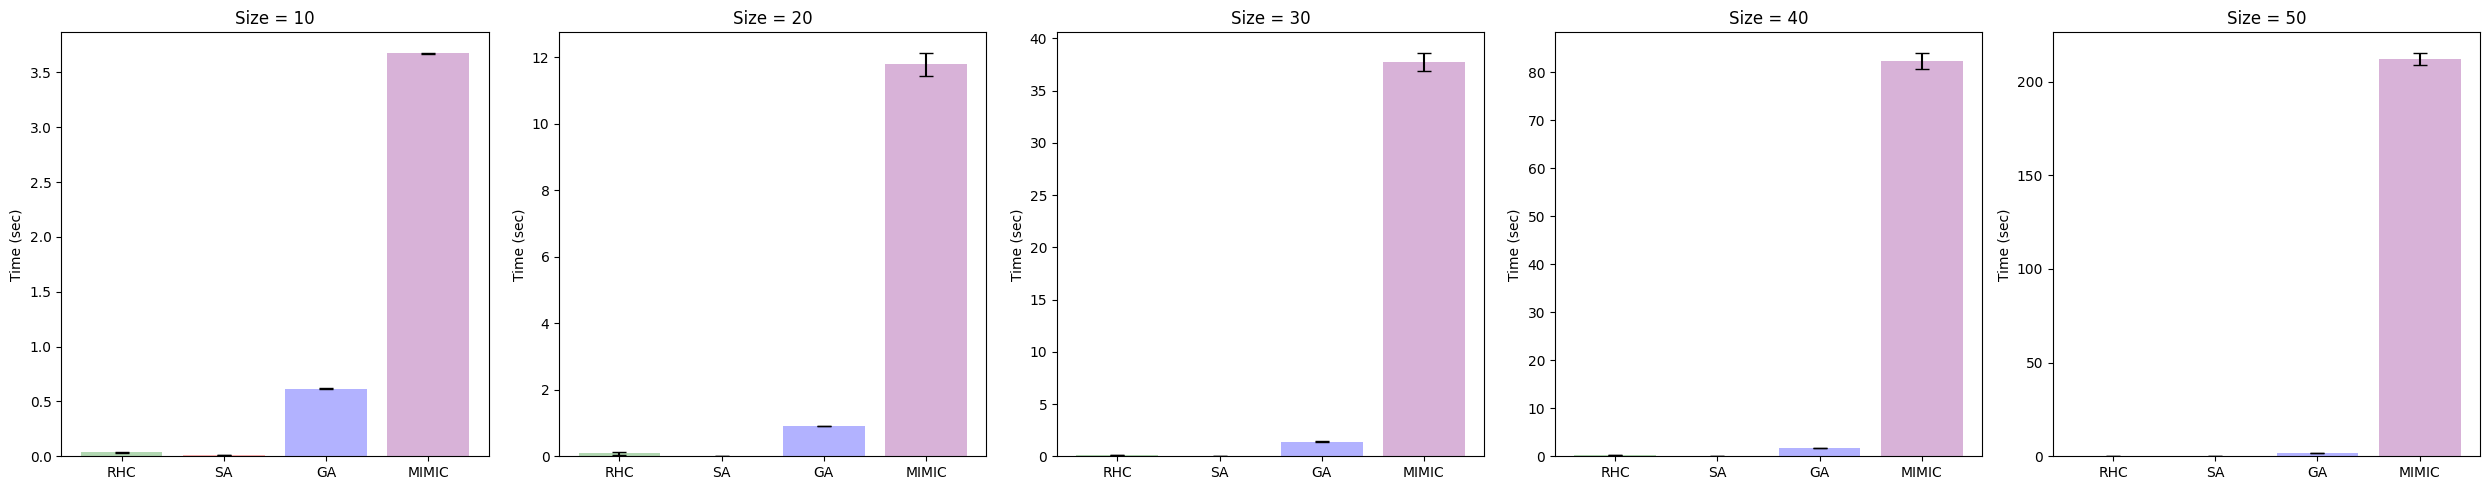

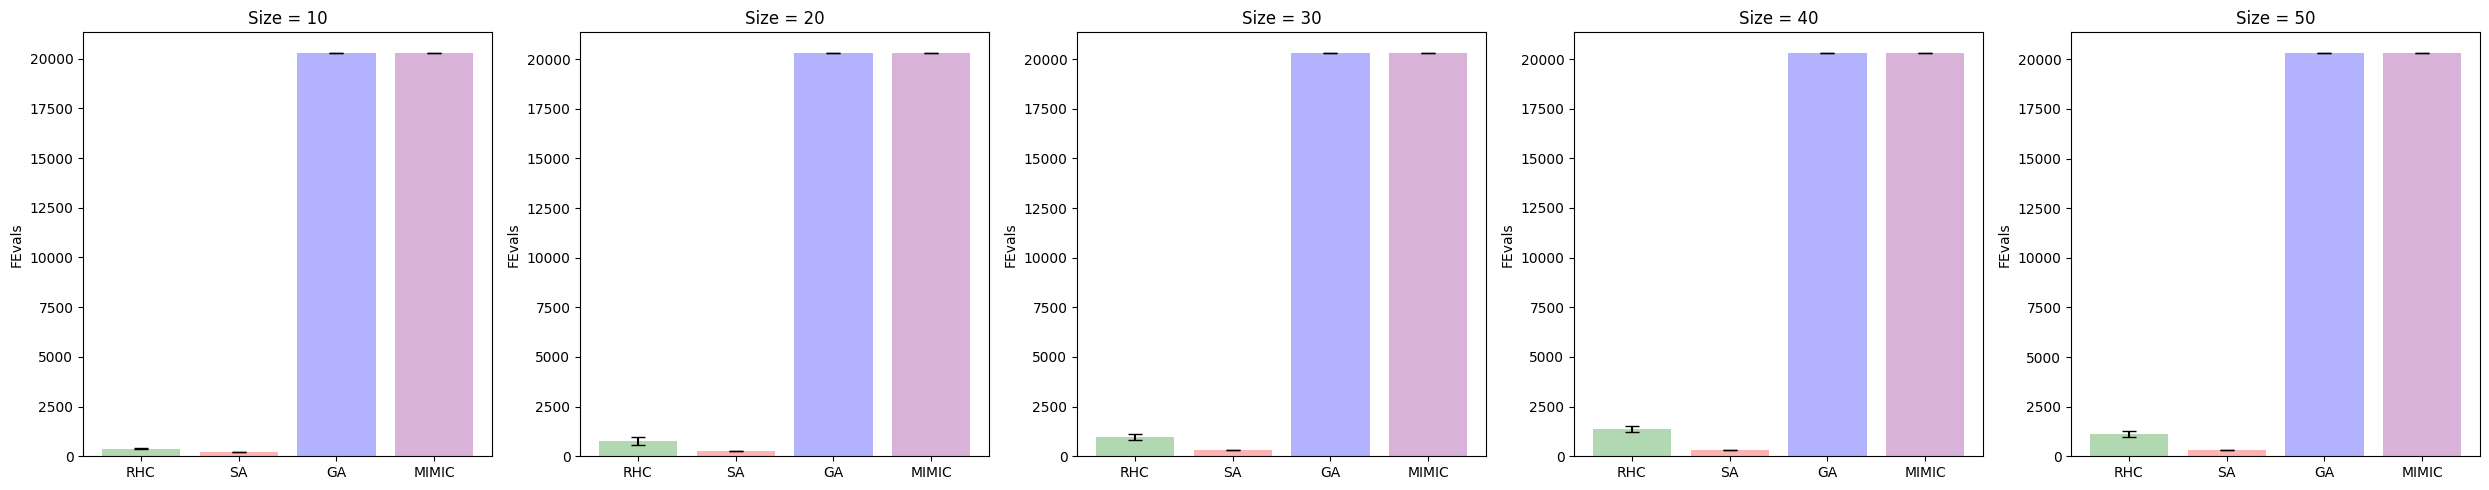

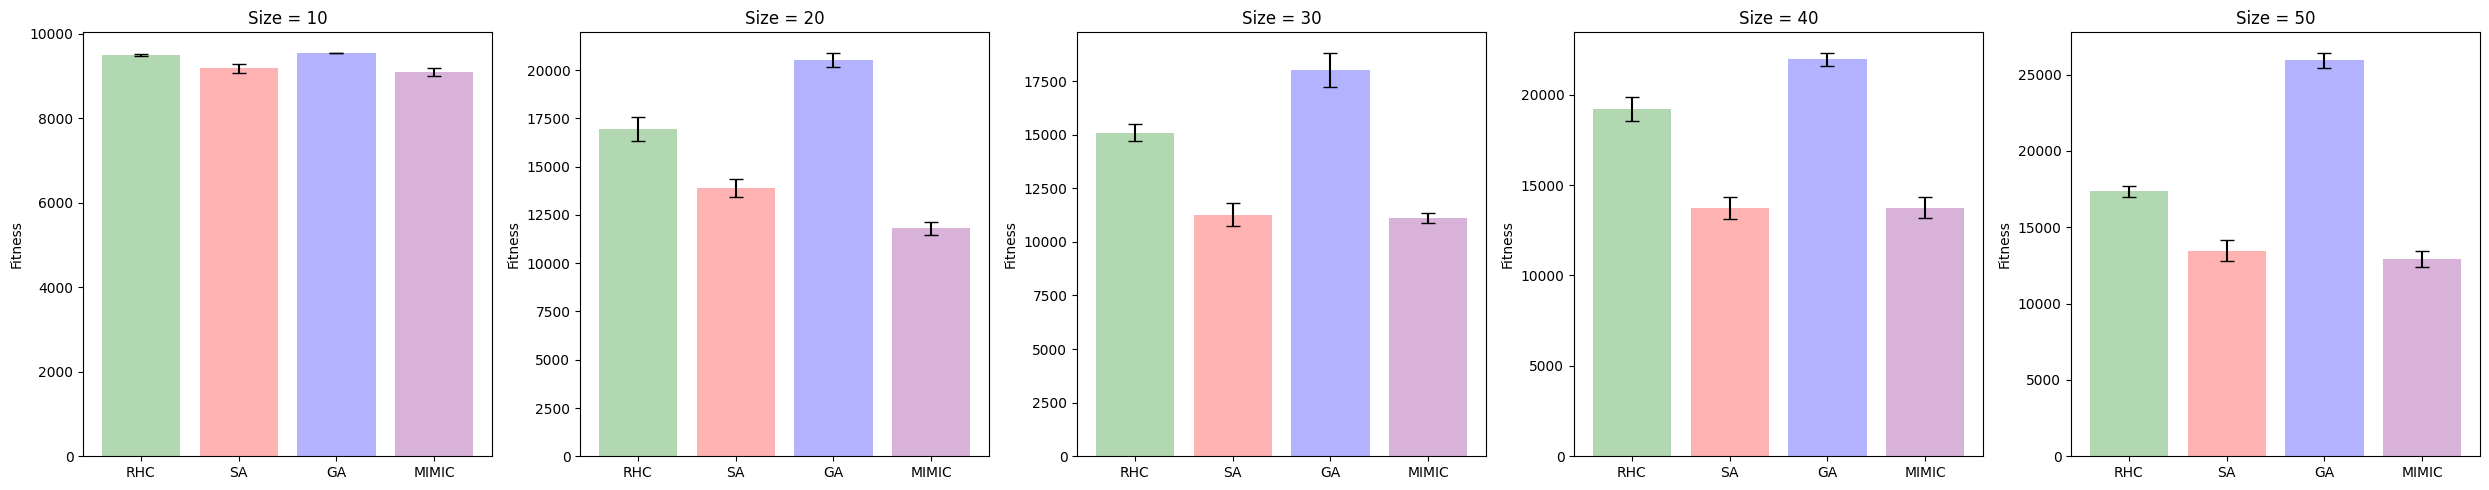

In [30]:
import matplotlib.pyplot as plt
import pickle

filename = "MTSP_RESULTS.pickle"

with open(filename, "wb") as f:
  pickle.dump(results, f)

for j in [["mean_time", "sem_time"], ["mean_feval", "sem_feval"], ["mean_fit", "sem_fit"]]:
  k = 0
  fig, ax = plt.subplots(1,5, figsize=(25, 5))
  
  for i in results:

    ax[k].bar(x = ["RHC", "SA", "GA", "MIMIC"], height = results[i][j[0]],
            yerr = results[i][j[1]], capsize=5, color=["Green", "Red", "Blue", "Purple"], alpha=0.3)
    ax[k].set_ylabel("Time (sec)" if j[0] == "mean_time" else ("FEvals" if j[0] == "mean_feval" else ("Fitness" if j[0] == "mean_fit" else "Iterations")))
    ax[k].set_title(f"Size = {[10, 20, 30, 40, 50][k]}")
    k += 1
  fig.tight_layout()

In [ ]:
import pickle

filename = "CUSTOMTSP_RESULTS.pickle"

with open(filename, "wb") as f:
  pickle.dump(results, f)

In [ ]:
import matplotlib.pyplot as plt


for j in [["mean_time", "sem_time"], ["mean_feval", "sem_feval"], ["mean_fit", "sem_fit"]]:
  k = 0
  fig, ax = plt.subplots(1,6, figsize=(30, 5))
  for i in results:

    ax[k].bar(x = ["RHC", "SA", "GA", "MIMIC"], height = results[i][j[0]],
            yerr = results[i][j[1]], capsize=5, color=["Green", "Red", "Blue", "Purple"], alpha=0.3)
    ax[k].set_ylabel("Time (sec)" if j[0] == "mean_time" else ("FEvals" if j[0] == "mean_feval" else "Fitness"))
    ax[k].set_title(f"Size = {[10, 20, 30, 40, 50][k]}")
    k += 1

In [32]:
rhc = mlrose.RHCRunner(problem=problem,
                        experiment_name='countones_ra',
                        output_directory="results/countones_ga",
                        seed=None,
                        iteration_list=2 ** np.arange(14),
                         early_stoppting = True,
                        max_attempts=200,
                        max_iters = 2000,
                        restart_list=[0], learning_rate = [0.75])
rhc_run_stats, rhc_run_curves = rhc.run()


sa = mlrose.SARunner(problem=problem,
                        experiment_name='countones_sa',
                        output_directory=None,
                        seed=None,
                       early_stoppting = True,
                        iteration_list=2 ** np.arange(14),
                        max_iters=200,
                        max_attempts=2000,
                        temperature_list=[1],
                        decay_list=[mlrose.GeomDecay],
                        learning_rate = 0.5)
sa_run_stats, sa_run_curves = sa.run()


ga = mlrose.GARunner(problem=problem,
                        experiment_name='countones_ga',
                        output_directory=None,
                        seed=None,
                       early_stoppting = True,
                        iteration_list=2 ** np.arange(14),
                        max_iters=200,
                        max_attempts=2000,
                        population_sizes =[100],
                        mutation_rates = [0.1])
ga_run_stats, ga_run_curves = ga.run()


mimic = mlrose.MIMICRunner(problem=problem,
                           experiment_name="MIMIC_final",
                           output_directory="results/CustomTSP_problem",
                           seed=None,
                             early_stoppting = True,
                           iteration_list=2 ** np.arange(14),
                           population_sizes=[100],
                           max_iters = 200,
                           max_attempts=2000,
                           keep_percent_list=[0.75],
                           use_fast_mimic=True)
mimic_run_stats, mimic_run_curves = mimic.run()

In [33]:
import ast
def convert_string_to_list(string):
    # Use ast.literal_eval to safely evaluate the string
    return ast.literal_eval(string)

# Example string
string = ga_run_stats["State"].iloc[-1]

# Convert the string to a list
best_state = convert_string_to_list(string)
print(best_state[0:33])

[33, 25, 24, 21, 17, 36, 48, 46, 27, 15, 20, 40, 19, 9, 16, 0, 2, 6, 39, 37, 10, 42, 44, 11, 34, 29, 4, 49, 35, 13, 3, 26, 47]


In [39]:
def path_travelled(best_state, max_distance_travelled = 300):
  # Iterate through the list of coordinates
  travel = []
  total_distance = 0
  coords = [coords_list[i] for i in best_state]
  for i in range(len(best_state) - 1):
    # Calculate the Euclidean distance between consecutive cities
    total_distance += math.sqrt((coords[i+1][0] - coords[i][0])**2 + (coords[i+1][1] - coords[i][1])**2)
    if total_distance < max_distance_travelled:
      travel.append(coords[i])
    else:
      return(travel)

In [42]:
# Plot the path
def plot_travel(coords = coords_list,
                rhc_run_stats = rhc_run_stats,
                ga_run_stats = ga_run_stats,
                sa_run_stats = sa_run_stats,
                mimic_run_stats = mimic_run_stats):
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    l = 0
    for stat, name, color in zip([rhc_run_stats, sa_run_stats, ga_run_stats, mimic_run_stats],
                          ["RHC", "SA","GA", "MIMIC"], ["Green", "Red", "Blue", "Purple"]):
        best_state = convert_string_to_list(stat.State.iloc[-1])
        travel =  path_travelled(best_state,max_distance_travelled = 300)
        print(len(travel))
        ax[l].scatter([i for i,_,_ in coords], [j for _,j,_ in coords], sizes =[k for _,_,k in coords], color="Black", alpha=0.3)
        ax[l].plot([i for i,_,_ in travel], [j for _,j,_ in travel], color = color, linewidth = 2, alpha=0.8)
        ax[l].set_title(f"{name}, {int(stat.Fitness.iloc[-1])}")
        l += 1
    # plt.plot([travel[-1][0], travel[0][0]] , [travel[-1][1], travel[0][1]], 'b')

14
12
17
14


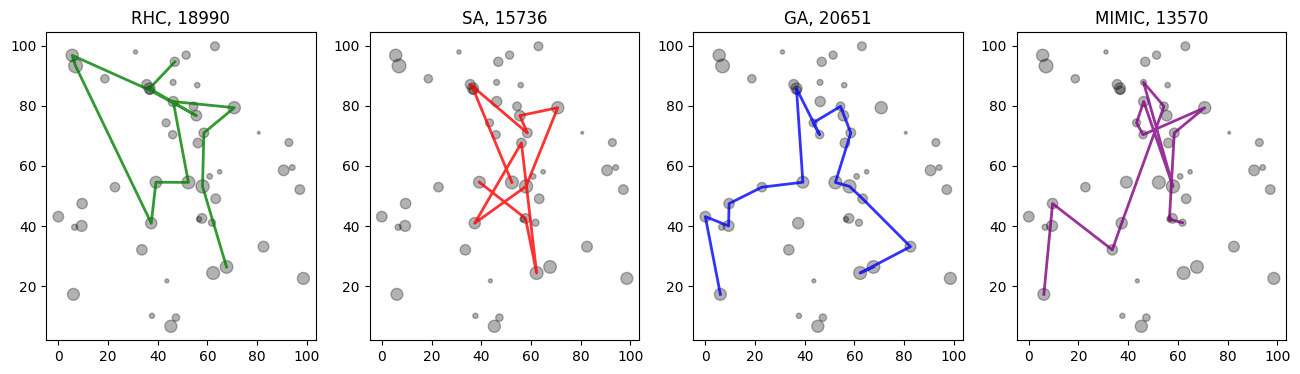

In [43]:
plot_travel()